In [2]:
from google.colab import drive
drive.mount('/content/drive')
import os
import sys
os.chdir('/content/drive/My Drive/ProyectoIA2/generative-spectral-datasets')

Mounted at /content/drive


In [3]:
import tensorflow as tf
import numpy as np
from models.main import make_autoencoder, make_discriminator
from models.layers import Discriminatorpix2pix
import matplotlib.pyplot as plt

input_shape = (32,32,3)

In [4]:
(train_images, train_labels), (_, _) = tf.keras.datasets.cifar10.load_data()

train_images = train_images.reshape(train_images.shape[0], 32, 32, 3).astype('float32')
train_images = train_images / 255

BUFFER_SIZE = 60000
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

170508288/170498071 [==============================] - 2s 0us/step


In [5]:
print(train_images.shape)

(50000, 32, 32, 3)


In [17]:
mse_loss = tf.keras.losses.MeanSquaredError()

def discriminator_loss(real_output, fake_output):
    loss = tf.math.log(real_output) + tf.math.log(1 - fake_output)
    return - tf.math.reduce_mean(loss)
    
def autoencoder_loss(real_x, estimated_x, real_output, fake_output, tau=0.001):
    autoencoder_loss = mse_loss(real_x, estimated_x)
    gan_loss =  tau*discriminator_losspix2pix(real_output, fake_output)
    total_loss = autoencoder_loss - gan_loss
    return total_loss

def discriminator_losspix2pix(disc_real_output, disc_generated_output):
  loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

A_optimizer = tf.keras.optimizers.Adam(1e-4)
D_optimizer = tf.keras.optimizers.Adam(1e-4)

FACTOR = [ 1 , 1 , 1/16 , 1/32 , 1/64, 1/256]
features= 256

A = make_autoencoder(input_shape, features=features, factors=FACTOR)

D = make_discriminator(input_shape, features=features, factors=FACTOR)
# discriminator = tf.keras.applications.mobilenet.MobileNet(input_shape=input_shape, classes=1, weights=None, classifier_activation='sigmoid')



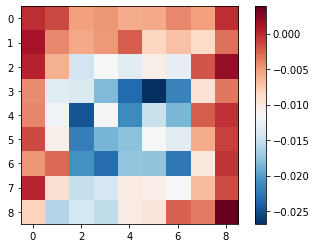

In [18]:
input_image = np.expand_dims(train_images[0, ...], axis = 0)
gen_output = A(input_image, training=False)

discriminator = Discriminatorpix2pix(in_shape = (32, 32, 3), tar_shape=(32,32,3))
plt.imshow(gen_output[0, ...])
disc_out = discriminator([input_image, gen_output ], training=False)
vmin = np.min(disc_out)
vmax = np.max(disc_out)
plt.imshow(disc_out[0, ..., -1], vmin=vmin, vmax=vmax, cmap='RdBu_r')
plt.colorbar()

In [19]:
images = next(iter(train_dataset))

generated_images = A(images, training=True)
real_output = discriminator([images, images], training=True)
fake_output = discriminator([images, generated_images], training=True)

# LOSS COMPUTING
A_loss = autoencoder_loss(images, generated_images, real_output, fake_output)
D_loss = discriminator_losspix2pix(real_output, fake_output)

print(D_loss)
print(A_loss)

tf.Tensor(1.5664089, shape=(), dtype=float32)
tf.Tensor(0.2718461, shape=(), dtype=float32)


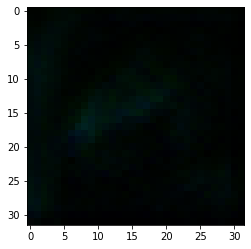

In [23]:
plt.imshow(gen_output[0, ...], vmin = np.min(gen_output), vmax = np.max(gen_output))

In [24]:
A.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
encoder_4 (Encoder)          (None, 32, 32, 1)         424466    
_________________________________________________________________
generator_2 (Generator)      (None, 32, 32, 3)         424470    
Total params: 848,936
Trainable params: 848,936
Non-trainable params: 0
_________________________________________________________________


In [25]:
D.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
discriminator_2 (Discriminat (None, 32, 32, 1)         424474    
Total params: 424,474
Trainable params: 424,474
Non-trainable params: 0
_________________________________________________________________


In [26]:
discriminator.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
target_image (InputLayer)       [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 32, 32, 6)    0           input_image[0][0]                
                                                                 target_image[0][0]               
__________________________________________________________________________________________________
sequential_14 (Sequential)      (None, 16, 16, 64)   6144        concatenate_7[0][0]        

In [27]:
@tf.function
def train_step(images, step):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

    # INFERENCE
    generated_images = A(images, training=True)

    # Argumentos para deducir real_output: discriminator([input_image, target])
    real_output = discriminator([ images, generated_images], training=True)

    #Argumentos para deducir fake_output: discriminator([input_image, spectral2grayscale(generated_image) ])
    fake_output = discriminator([images, generated_images], training=True)

    # LOSS COMPUTING
    A_loss = autoencoder_loss(images, generated_images, real_output, fake_output)
    D_loss = discriminator_losspix2pix(real_output, fake_output)
  # BACKPROPAGATION
  A_gradients = gen_tape.gradient(A_loss, A.trainable_variables)
  D_gradients = disc_tape.gradient(D_loss, discriminator.trainable_variables)

  A_optimizer.apply_gradients(zip(A_gradients, A.trainable_variables))
  D_optimizer.apply_gradients(zip(D_gradients, discriminator.trainable_variables))
  return A_loss , D_loss


def train(dataset, epochs):
  print("START TRAINING")
  for epoch in range(epochs):

    ae_total_loss = []
    disc_total_loss = []

    for image_batch in dataset:
      gen_loss , disc_loss = train_step(image_batch, epoch + 1)

      ae_total_loss.append(float(gen_loss))
      disc_total_loss.append(float(disc_loss))
      print("Autoencoder loss: %.4f | Discriminator loss: %.4f" % (float(gen_loss), float(np.array(disc_loss)))) 

    ae_total_loss = np.mean(ae_total_loss)
    disc_total_loss = np.mean(disc_total_loss)

    
    print("TOTAL: Autoencoder loss: %.4f | Discriminator loss: %.4f" % (float(ae_total_loss), float(np.array(disc_total_loss)))) 

  print("END TRAINING")


In [29]:
EPOCHS = 1
train(train_dataset, EPOCHS)

START TRAINING
Autoencoder loss: 0.0111 | Discriminator loss: 0.9590
Autoencoder loss: 0.0118 | Discriminator loss: 0.9438
Autoencoder loss: 0.0112 | Discriminator loss: 0.9705
Autoencoder loss: 0.0113 | Discriminator loss: 0.9692
Autoencoder loss: 0.0114 | Discriminator loss: 0.9663
Autoencoder loss: 0.0110 | Discriminator loss: 0.9617
Autoencoder loss: 0.0099 | Discriminator loss: 0.9685
Autoencoder loss: 0.0102 | Discriminator loss: 0.9605
Autoencoder loss: 0.0100 | Discriminator loss: 0.9568
Autoencoder loss: 0.0097 | Discriminator loss: 0.9546
Autoencoder loss: 0.0107 | Discriminator loss: 0.9535
Autoencoder loss: 0.0095 | Discriminator loss: 0.9581
Autoencoder loss: 0.0108 | Discriminator loss: 0.9683
Autoencoder loss: 0.0105 | Discriminator loss: 0.9866
Autoencoder loss: 0.0092 | Discriminator loss: 1.0064
Autoencoder loss: 0.0090 | Discriminator loss: 0.9786
Autoencoder loss: 0.0092 | Discriminator loss: 0.9853
Autoencoder loss: 0.0108 | Discriminator loss: 1.0070
Autoencoder l

In [30]:
x = next(iter(train_dataset))

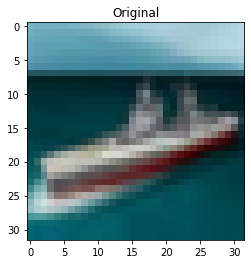

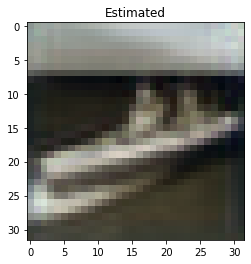

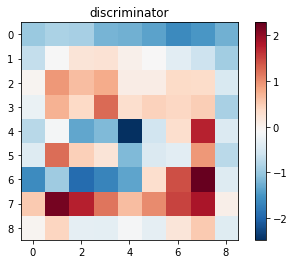

In [32]:
x_estimated = A.predict(x)

import matplotlib.pyplot as plt

num = np.random.randint(0, x.shape[0])

plt.title("Original")
plt.imshow(x[num,:,:])
plt.show()

plt.title("Estimated")
plt.imshow(x_estimated[num,:,:])
plt.show()

x_discriminator = discriminator.predict([input_image, np.expand_dims(x_estimated[num,...], axis =0)])
plt.title("discriminator")
plt.imshow(x_discriminator[0,...,-1], cmap='RdBu_r')
plt.colorbar()
plt.show()
